In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualizationdf_e.shape
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Load the dataset
df_e = pd.read_csv('/Users/ayushyapare/Desktop/Ayushyas_Life/Work/Projects/Final_Project/Housing_Price_Prediction_Madrid/data/processed/additional_data.csv')
#df_e = pd.read_csv('/Users/ayushyapare/Desktop/Ayushyas_Life/Work/Projects/Final_Project/Housing_Price_Prediction_Madrid/data/processed/Additional_Dataset_wo_null_ayushya.csv', index_col=0)


In [3]:
import warnings
warnings.filterwarnings("ignore")


#### Remove outliers

#### 1. Price

<Axes: xlabel='price', ylabel='Count'>

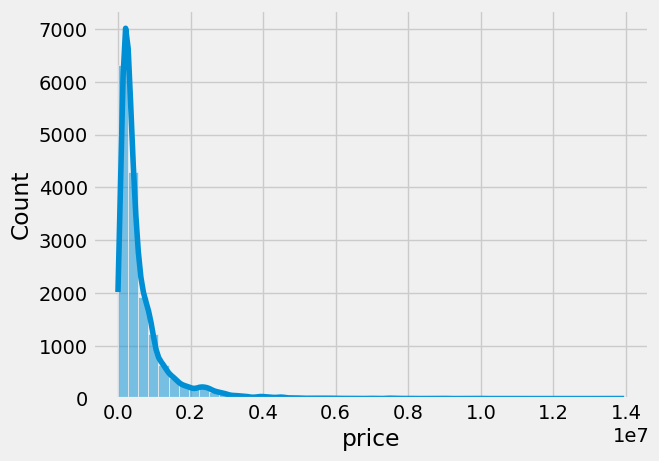

In [4]:
sns.histplot(df_e['price'],kde = True,bins=50)

<Axes: xlabel='price', ylabel='Count'>

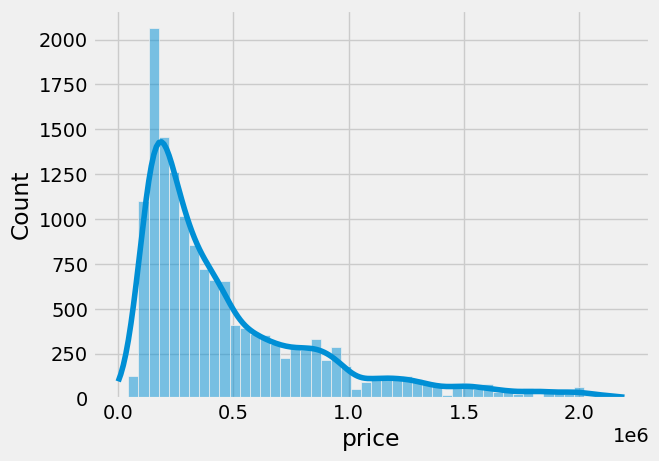

In [5]:

q = df_e['price'].quantile(0.95)

df_e = df_e[df_e['price']<q]

sns.histplot(df_e['price'],kde = True,bins=50)

#### 2. Rooms

<Axes: xlabel='rooms', ylabel='Count'>

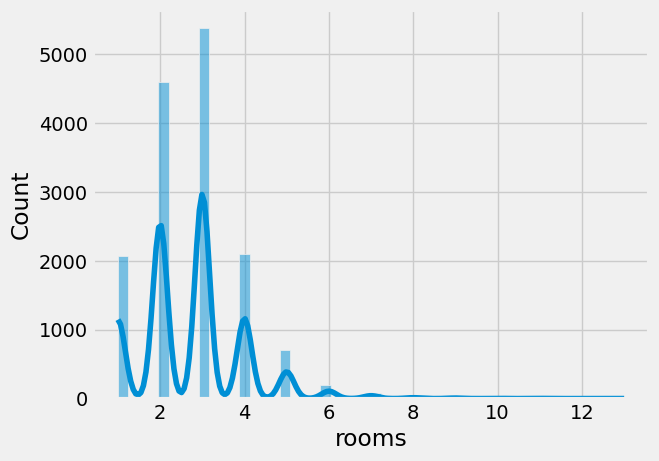

In [6]:
sns.histplot(df_e['rooms'],kde = True,bins=50)

<Axes: xlabel='rooms', ylabel='Count'>

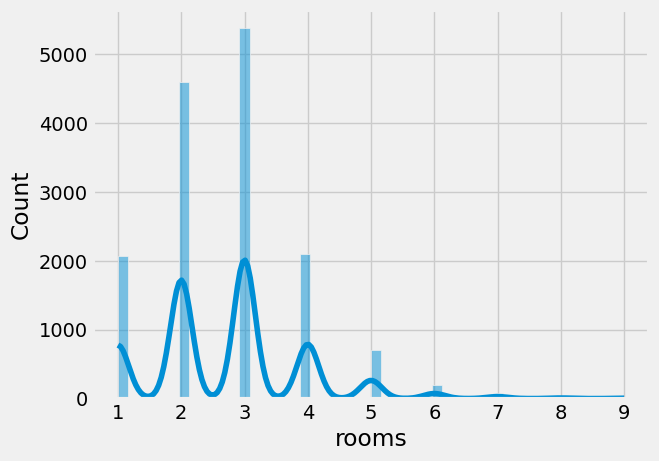

In [7]:

df_e = df_e[df_e['rooms']<10]

sns.histplot(df_e['rooms'],kde = True,bins=50)

#### 3. Area (m2)

<Axes: xlabel='m2', ylabel='Count'>

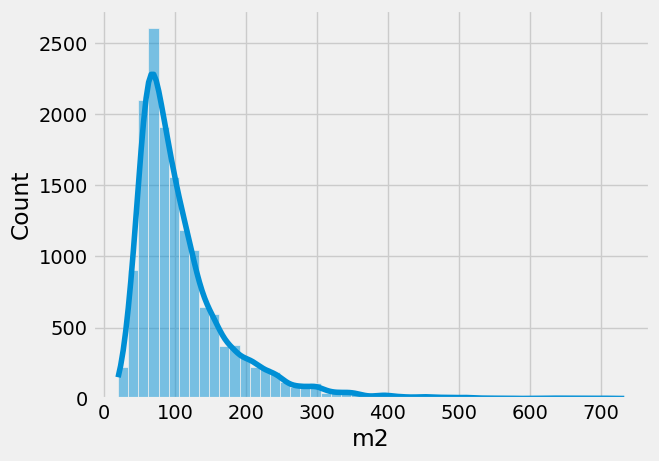

In [8]:
sns.histplot(df_e['m2'], kde = True, bins = 50)

<Axes: xlabel='m2', ylabel='Count'>

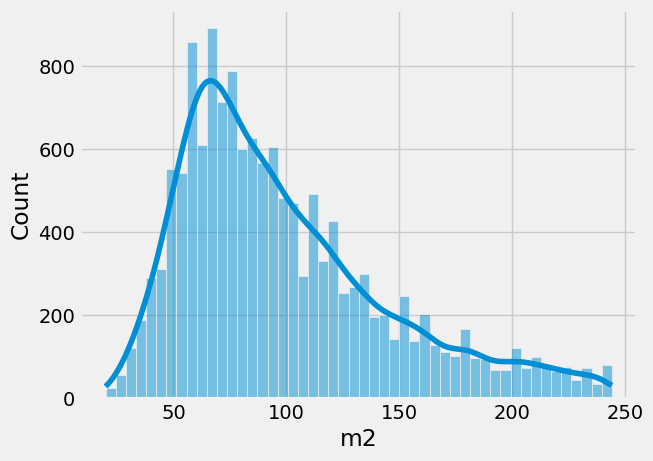

In [9]:
q = df_e['m2'].quantile(0.95)

df_e = df_e[df_e['m2']<q]

sns.histplot(df_e['m2'],kde = True,bins=50)

#### Data Cleaning

In [10]:
df_e_without_duplicates = df_e.drop_duplicates()

In [11]:
df_e_without_duplicates.isna().sum()

price             0
house_type        0
house_type_2    449
rooms             0
m2                0
elevator          0
garage            0
neighborhood      0
district          0
dtype: int64

In [12]:
df_e_without_duplicates_without_na = df_e_without_duplicates.dropna()

In [13]:
df_e_without_duplicates_without_na.isna().sum()

price           0
house_type      0
house_type_2    0
rooms           0
m2              0
elevator        0
garage          0
neighborhood    0
district        0
dtype: int64

In [14]:
df_e_without_duplicates_without_na.shape

(12391, 9)

In [15]:
df = df_e_without_duplicates_without_na

In [16]:
# Create the new columns
df['house_type_'] = df['house_type']
df['floor'] = 'n/a'

In [17]:
import re
# Function to categorize house_type_ and floor
def categorize_house_type(house_type):
    match = re.match(r'^planta\s*(-?\d+)$', house_type)
    if match:
        return 'Apartment', match.group(1)
    else:
        return house_type, 'n/a'

# Apply the function to the DataFrame and create new columns
df[['house_type_', 'floor']] = df['house_type'].apply(lambda x: pd.Series(categorize_house_type(x)))

print(df)

        price house_type house_type_2  rooms     m2  elevator  garage  \
0      495000   planta 1     exterior      3  118.0      True    True   
1      485000   planta 2     exterior      2   82.0      True    True   
2      315000   planta 2     exterior      2   72.0     False   False   
3      585000   planta 4     exterior      2  174.0      True    True   
4      255000       bajo     exterior      3   75.0     False   False   
...       ...        ...          ...    ...    ...       ...     ...   
15969  380000   planta 5     exterior      3   90.0      True    True   
15971  108000   planta 3     exterior      3   60.0     False   False   
15972  140000       bajo     exterior      2   65.0     False   False   
15973  135000   planta 1     exterior      2   71.0     False   False   
15974  150000   planta 4     exterior      4   71.0      True   False   

          neighborhood    district house_type_ floor  
0              Chopera  Arganzuela   Apartment     1  
1      Palos 

In [18]:
df['house_type_'].value_counts()

house_type_
Apartment      10223
bajo            1724
entreplanta      210
chalet            77
semi-sotano       72
casa              55
sotano            30
Name: count, dtype: int64

In [19]:
df.drop(columns=['house_type'], inplace=True)

In [20]:
df['floor'].replace('n/a','0',inplace=True)

In [21]:
df['floor'].value_counts()

floor
1     2592
2     2205
0     2168
3     1901
4     1378
5      833
6      497
7      310
8      173
9      118
10      69
11      42
13      33
12      27
-1      13
14      10
15       7
18       5
16       4
20       4
19       2
Name: count, dtype: int64

In [22]:
# Convert 'floor' column to numeric, setting errors='coerce' to handle invalid values
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')

print(df['floor'].dtype)  # This should now print 'int64'


int64


### Neural Network

In [23]:
#df = pd.read_csv('/Users/ayushyapare/Desktop/Ayushyas_Life/Work/Projects/Final_Project/Housing_Price_Prediction_Madrid/data/processed/df_normalized.csv', index_col=0)

In [24]:
#pip install tensorflow

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [26]:
df.columns

Index(['price', 'house_type_2', 'rooms', 'm2', 'elevator', 'garage',
       'neighborhood', 'district', 'house_type_', 'floor'],
      dtype='object')

In [27]:
from sklearn.model_selection import train_test_split

X = df.drop('price',axis =1)
y = df['price']


In [28]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Define the preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Fit and transform the training data, and transform the test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [29]:
model = Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1))

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss='mse')

In [31]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=128,
    epochs=200)


Epoch 1/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 271139667968.0000 - val_loss: 22942273536.0000
Epoch 2/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 23707641856.0000 - val_loss: 15929543680.0000
Epoch 3/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 17926477824.0000 - val_loss: 15248528384.0000
Epoch 4/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 16703495168.0000 - val_loss: 14784865280.0000
Epoch 5/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 15714170880.0000 - val_loss: 15090758656.0000
Epoch 6/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 15565345792.0000 - val_loss: 20006387712.0000
Epoch 7/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 16628630528.0000 - val_loss: 14179085312.0000
Epoch 8/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 14971208704.0000 - val_loss: 13956908032.0000
Epoch 9/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 14668775424.0000 - val_loss: 14692639744.0000
Epoch 10/200
78/78 ━━━━━━━━━━━━━━━━━━━

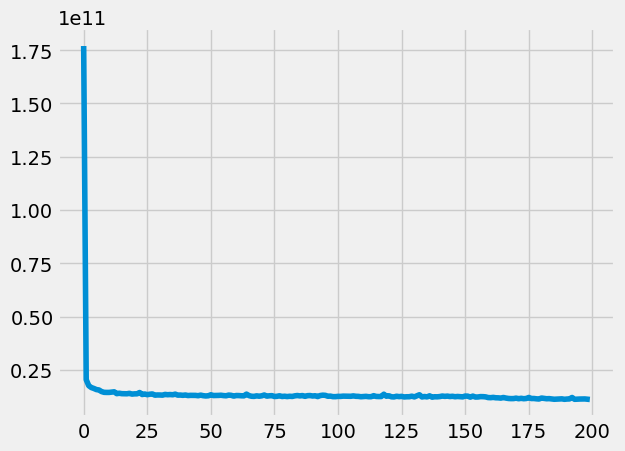

In [32]:
plt.plot(model.history.history['loss'])

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
MAE: 72736.8470685004
MSE: 14424197755.410933
RMSE: 120100.78166028285
R2 Score: 0.868521125365272


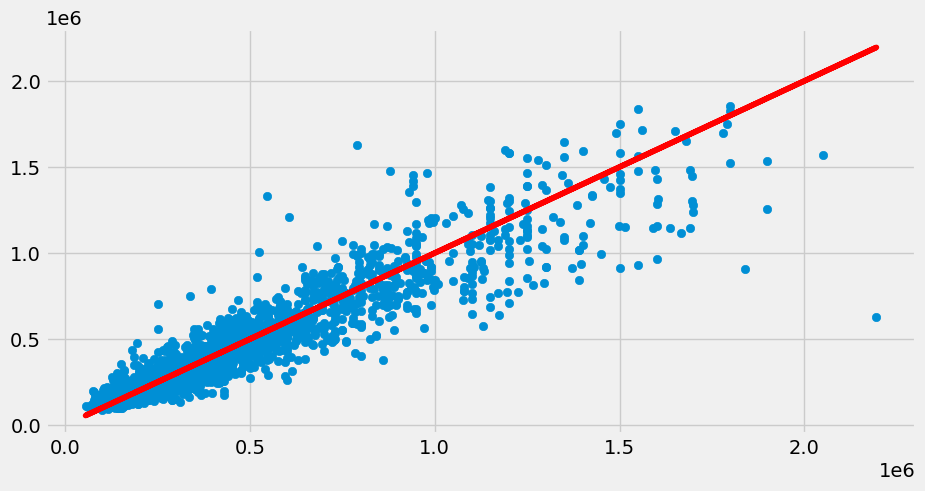

In [33]:
from sklearn import metrics


y_pred = model.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:',metrics.explained_variance_score(y_test,y_pred))

# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')


In [34]:
df.head(2)

price house_type_2  rooms     m2  elevator  garage     neighborhood  \
0  495000     exterior      3  118.0      True    True          Chopera   
1  485000     exterior      2   82.0      True    True  Palos de Moguer   

     district house_type_  floor  
0  Arganzuela   Apartment      1  
1  Arganzuela   Apartment      2